In [1]:
from scipy.io import loadmat
import cv2
import numpy as np
from utilities import visualize_brain_maps, EarlyStoppingCallback
from tensorboard import notebook
from architectures import CCA, deepCCA

#notebook.list()
#!tensorboard --logdir 'LOG' --port 6006

# Loading simulated spatial maps $\mathbf{S}_{\mathbf{X}}$ and $\mathbf{S}_{\mathbf{X}}$
-------
### The following code is based on the model where the first view is $\mathbf{X}=\mathbf{M}_{\mathbf{X}}\mathbf{S}_{\mathbf{X}}$ and the second view $\mathbf{Y}=\mathbf{M}_{\mathbf{Y}}\mathbf{S}_{\mathbf{Y}}$. Sources $\mathbf{S}_{\mathbf{X}}$ and $\mathbf{S}_{\mathbf{Y}}$ have an unknown underlying relationship. Applying a nonlinearity to the sources makes the relationship more complex and motivates the work of deepCCA to unveil nonlinear relationships in multi-view data.

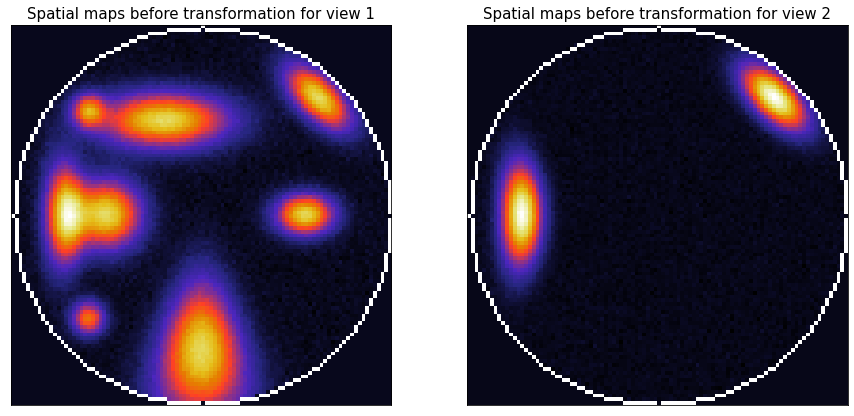

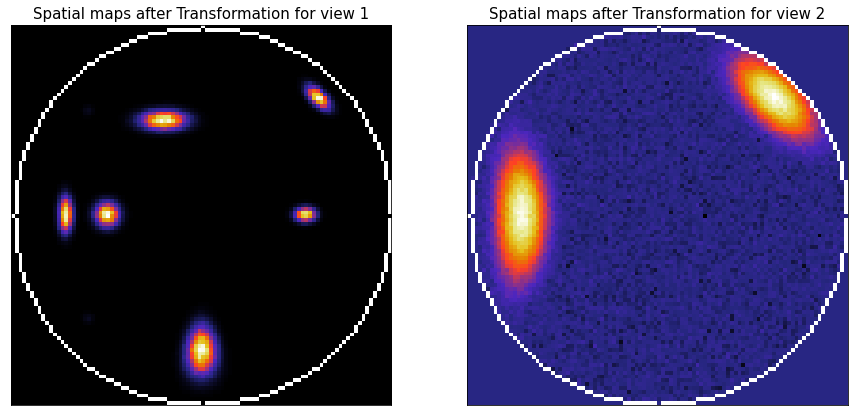

In [2]:
S_X = cv2.normalize(loadmat('simtb/set_subject_001_SIM.mat')['SM'], None, 0, 255, cv2.NORM_MINMAX)
S_Y = cv2.normalize(loadmat('simtb/set_subject_002_SIM.mat')['SM'], None, 0, 255, cv2.NORM_MINMAX)[:2]

visualize_brain_maps(S_X, S_Y, 'Spatial maps before transformation')

M_X = np.random.randn(200, 5)
M_Y = np.random.randn(200, 2)

S_X_T = cv2.normalize(np.power(S_X, 10), None, 0, 255, cv2.NORM_MINMAX)
S_Y_T = cv2.normalize(np.power(S_Y, 0.5), None, 0, 255, cv2.NORM_MINMAX)

visualize_brain_maps(S_X_T, S_Y_T, 'Spatial maps after Transformation')

# Creating final data $\mathbf{X}$ and $\mathbf{Y}$.

In [3]:
X = np.matmul(M_X, S_X_T)
Y = np.matmul(M_Y, S_Y_T)

# Applying CCA to $\mathbf{X}$ and $\mathbf{Y}$.

In [4]:
_, _, epsilon, omega, _ = CCA(view1=X, view2=Y, r1=1e-4, r2=1e-4, shared_dim=10)

estimated_S_X = cv2.normalize(epsilon.numpy(), None, 0, 255, cv2.NORM_MINMAX)
estimated_S_Y = cv2.normalize(omega.numpy(), None, 0, 255, cv2.NORM_MINMAX)

# Applying deepCCA to $\mathbf{X}$ and $\mathbf{Y}$.

In [5]:
model = deepCCA(input_nodes=[200, 200], hidden_layers=[[512, 512], [512, 512]], output_nodes=10)

Model for the 1st view

Sequential(
  (0): Linear(in_features=200, out_features=512, bias=True)
  (1): Sigmoid()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Sigmoid()
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (6): Linear(in_features=512, out_features=10, bias=True)
)

Model for the 2nd view

Sequential(
  (0): Linear(in_features=200, out_features=512, bias=True)
  (1): Sigmoid()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Sigmoid()
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (6): Linear(in_features=512, out_features=10, bias=True)
)


In [6]:
model.fit(view1=X, view2=Y, l2_param=1e-3, learning_rate=3e-4, optim='Adam', 
          epochs=1000, early_stopping_idx=100, early_stopping_epsilon= 1e-3, LOGPATH='LOG/Example')

100%|██████████| 1000/1000 [10:26<00:00,  1.60it/s]


In [7]:
epsilon, omega = model.forward(X, Y)

estimated_S_X_deep = cv2.normalize(epsilon.detach().t().numpy(), None, 0, 255, cv2.NORM_MINMAX)
estimated_S_Y_deep = cv2.normalize(omega.detach().t().numpy(), None, 0, 255, cv2.NORM_MINMAX)

# Results
--------
### The example shows a possible scenario for applying deepCCA in the context of multi-view analysis and it is also an example where deepCCA is superior to CCA. However, it is yet to decide what a final condition stop training and to avoid overfitting could be. Furthermore, the true dimension of shared components is 2, in the course of the examples 15 was assumed to keep it more realistic. Choosing the correct dimension of output nodes is also far from trivial and has a strong influence on the performance.  

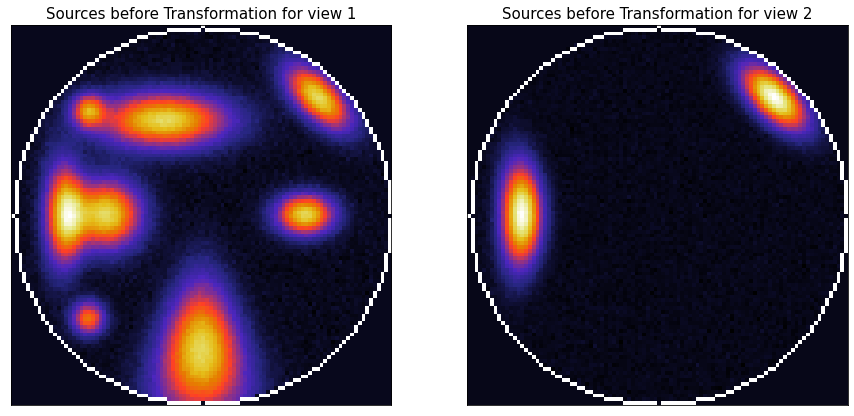

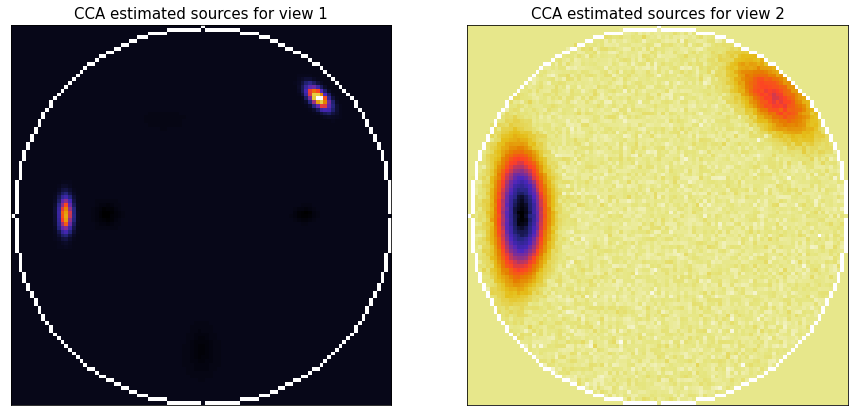

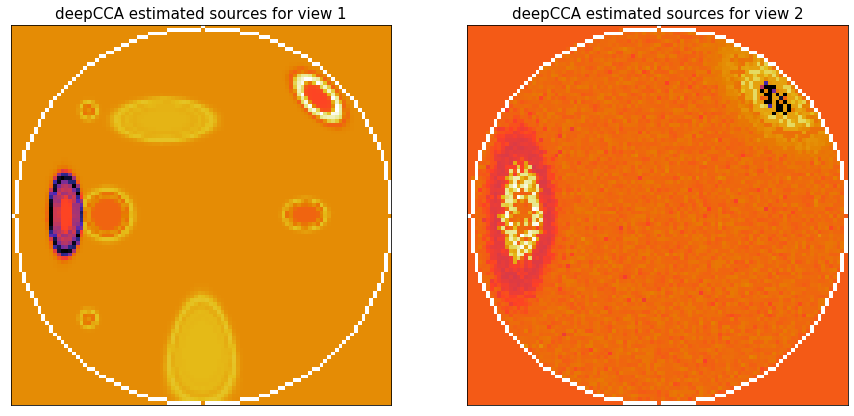

In [8]:
visualize_brain_maps(S_X, S_Y, 'Sources before Transformation')
visualize_brain_maps(estimated_S_X, estimated_S_Y, 'CCA estimated sources')
visualize_brain_maps(estimated_S_X_deep, estimated_S_Y_deep, 'deepCCA estimated sources')